# Support Vector Machine

For SCQC Summer School of Quantum Computing 2023 <br>
Yuri Kobayashi (June 13, 2023)

In machine learning, support vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regresion analysis.

In this tutorial, we will learn how to prepare, encode, train, and then clasify data using example data sets.


In [ ]:
import numpy as np

# for plotting results
import matplotlib.pyplot as plt

# Import Scikit-learn(QML library for Python)
from sklearn import datasets
from sklearn.model_selection import train_test_split # for splitting test data
from sklearn.svm import SVC # SVM Classification
from sklearn.decomposition import PCA # Principal component analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler # for standardization, normalization scale conversion

# Import Qiskit
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

## Prepare Data

Here we handle a subset of 0s and 1s from the handwritten digital image dataset (MNIST dataset).

In [ ]:
# Reads two classes of data (0 and 1) from a numeric data set
digits = datasets.load_digits(n_class=2)   

# Plot the first 100 images loaded
fig, axes = plt.subplots(10, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

This data set contains a total of 360 data points. Each data point is an 8 x 8 numbered image, in an array, with each element being an integer from 0 (white) to 16 (black). As with classical classification algorithms, the dataset must be divided and normalized into training (100) and testing (20) samples. To use this dataset for the quantum classification algorithm, the range is scaled between -1 and 1 and the dimension is reduced to the number of qubits used (4 in this case).

In [ ]:
print(digits.images[0])

In [ ]:
# Splitting the dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Delete dimension
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Standardize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Normalize
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select 100 for training and 20 for testing
train_size = 100
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [ ]:
# Display each of the first data
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

## Data encoding

This classical data is then encoded into the quantum state space using a quantum feature map (ZZFeatureMap).

In [ ]:
# ZZFeatureMap with 4 features and depth (number of iterations)1
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear', insert_barriers=True)
zz_map.decompose().draw('mpl')

## Quantum Kernel Computation

The quantum feature map $\phi(\vec{x})$ can be used to create a quantum kernel $k(\vec{x}_i,\vec{x}_j)= \phi(\vec{x}_j)^\dagger\phi(\vec{x}_i)$. This can be thought of a measure of how similar the two vectors are. The larger the closer the two $\vec{x}_i$ and $\vec{x}_j$ are.

In this case, we will use ZZFeatureMap to calculate the quantum kernel.

In [ ]:
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

For the 0th and 1st data in the training data, we create a quantum circuit to compute the quantum kernel and actually compute the kernel.

In [ ]:
print(sample_train[0])
print(sample_train[1])

In [ ]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

The parameter values for each rotation gate are a bit hard to read, but you can see that the circuit is symmetrical. The left half of the circuit is coded for the training data sample_train[0] and the right half for the training data sample_train[1].

As an example, measure the above quantum kernel and calculate the elements of the kernel matrix (for the zero and first data of the training data) as a percentage of the counts of zero states.

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [ ]:
counts['0000']/sum(counts.values())

This process is repeated for each pair of training data samples to fill the training kernel matrix, and then repeated between training and test data samples to fill the test kernel matrix. Note that since each matrix is symmetric, only half of the elements are computed to reduce computation time.

Calculate the kernel matrices for the training and test data using the QuantumKernel class.

In [ ]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## Training
We will train it using the `svc` algorithm of the classical SVM classifier `scikit-learn` and see the learning rate on test data.

In [ ]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, labels_train)    # Train
zzpc_score = zzpc_svc.score(matrix_test, labels_test)    # Determine the percentage of correct answers

print(f'Kernel classification test score: {zzpc_score}')


We can see that we have classified the test data points almost correctly.

# Classification of Clothing Image Data


The data we deal with here is a subset of the clothing image dataset [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md), which is a variant of the MNIST dataset which is a subset of the MNIST dataset.


<center><div><img src="fashion-mnist-sprite.png" width="640" /></div></center>

Image source:[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)

Let's classify images for the following labels

- label 2: pullovers
- label 3: dresses

First, load the dataset and display one image per class.

In [1]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# Import Scikit-learn(QML library for Python)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Import Qiskit
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

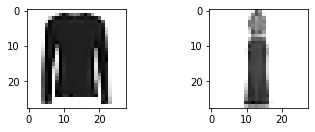

In [2]:
# Load data
DATA_PATH = 'fashion.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Splitting the dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Show data
fig = plt.figure()
LABELS = [2,3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(2, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

Next, let's preprocess the following datasets

- Standardization
- Dimensionality Compression by Principal Component Analysis (PCA)
- Normalization

The number of dimensions can be changed by changing N_DIM.

In [3]:
# change the dimension
N_DIM = 4
pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# standardize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# normalize
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [4]:
# Display each of the first data
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[ 0.57224382  0.42792237  0.51739071 -0.56183696] 2
[-0.06183403 -0.5422121   0.22973795 -0.64972228] 3


## Exercise

For this clothing image data, we compute a kernel matrix using a feature map (ZZFeatureMap) and a quantum kernel (QuantumKernel class) and train it using a classical SVM. Check the learning rate.

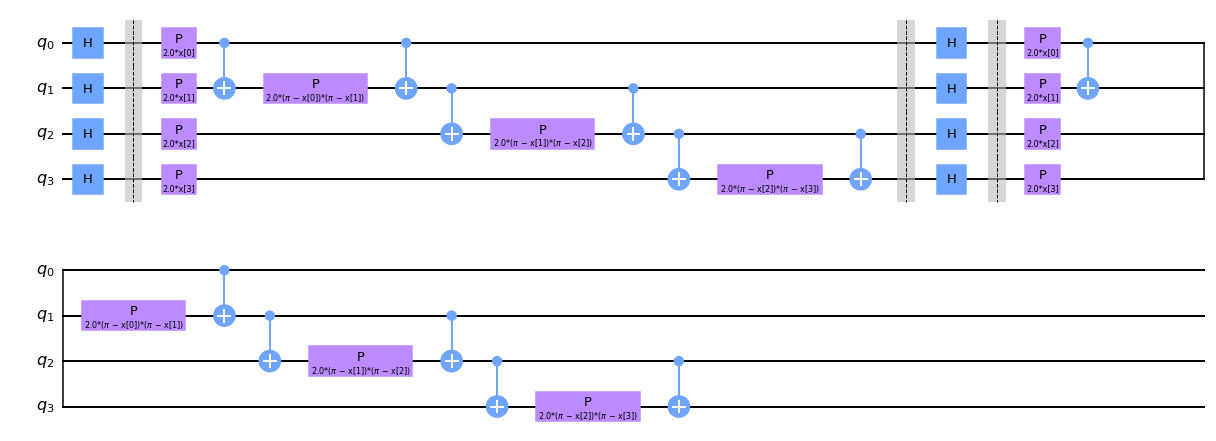

In [60]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="linear", insert_barriers=True)
zz_map.decompose().draw('mpl')

In [53]:
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

For the 0th and 1st data in the training data, we create a quantum circuit to compute the quantum kernel and actually compute the kernel.

In [54]:
print(sample_train[0])
print(sample_train[1])

[ 0.57224382  0.42792237  0.51739071 -0.56183696]
[0.46990302 0.37113103 0.32350877 0.12798183]


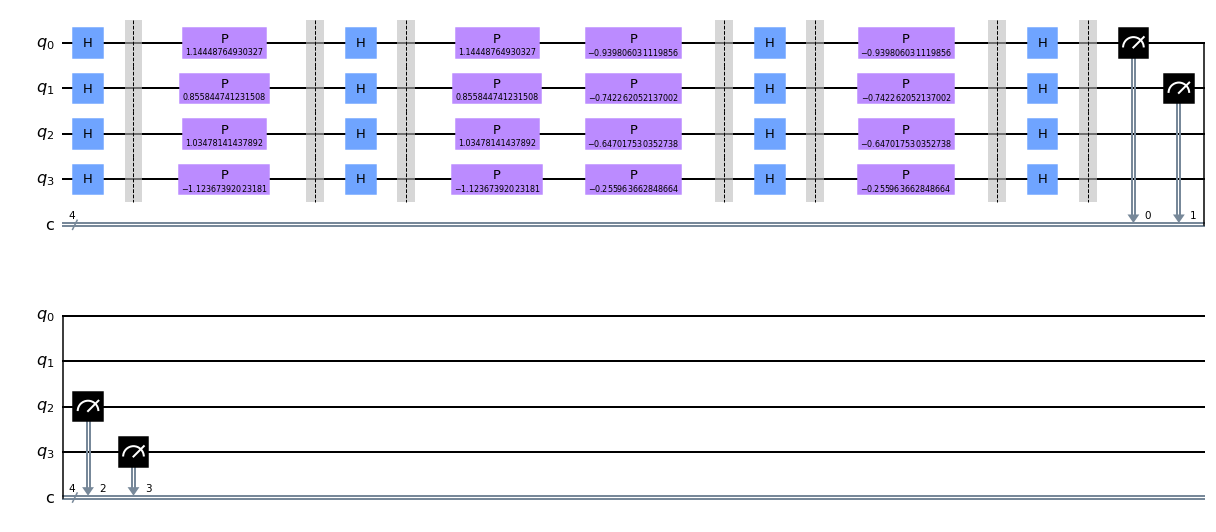

In [55]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl') 

In [56]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [57]:
counts['0000']/sum(counts.values())

0.6336669921875

Calculate the kernel matrices for the training and test data using the QuantumKernel class.

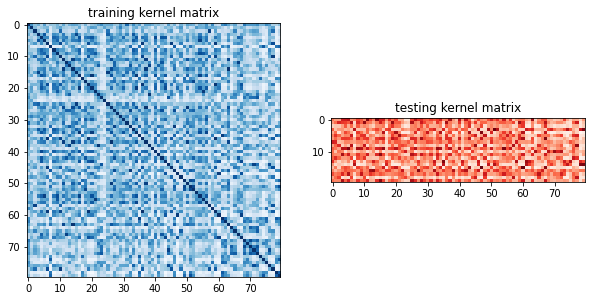

In [58]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

We will train it using the `svc` algorithm of the classical SVM classifier `scikit-learn` and see the learning rate on test data.

In [59]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, labels_train)    # Train
zzpc_score = zzpc_svc.score(matrix_test, labels_test)    # Determine the percentage of correct answers

print(f'Kernel classification test score: {zzpc_score}')

Kernel classification test score: 0.85


How was your classification test score?

Congratultaions! You were able to successfully create a classifier that distinguishes overalls from dresses! 